<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/T_SIS_edges_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# SIR

En esta parte está el código para un SIR usando agrupamiento de nodos. Se agrega la opción $Tuto=True$ para imprimir las acciones del algoritmo Gillespie y presentar los cambios en la gráfica. Se recomienda para gráficas de orden pequeño (e.g. N=10)

In [2]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False):
    flag=True

    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    X_R=0
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo 
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            X_I-=1
            X_R+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo 
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        
        if(X_I==0):
            flag=False
    return Historia

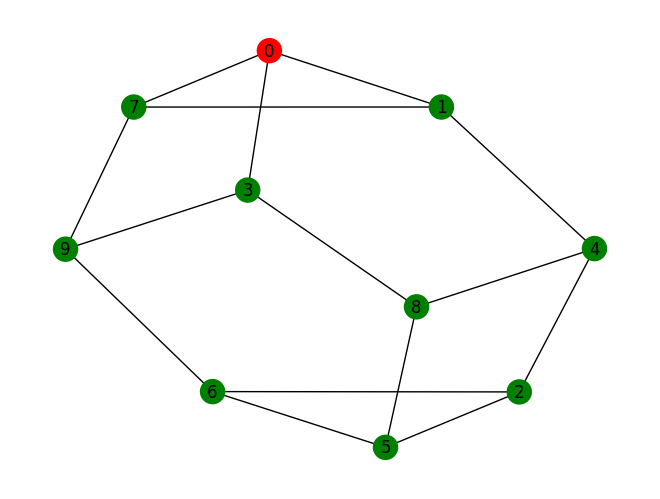

Empieza
Se genera el tiempo  0.004651548471746739
Se selecciona al individuo 1
infectado por estar en el grupo con  1


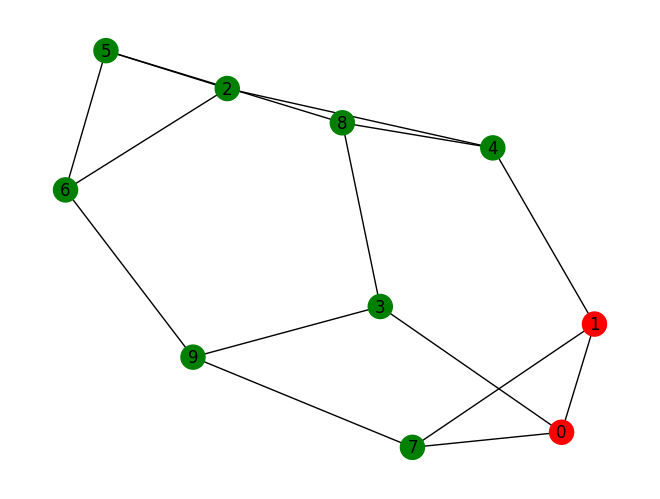

Se genera el tiempo  0.020820199696082904
Se selecciona al individuo 7
infectado por estar en el grupo con  2


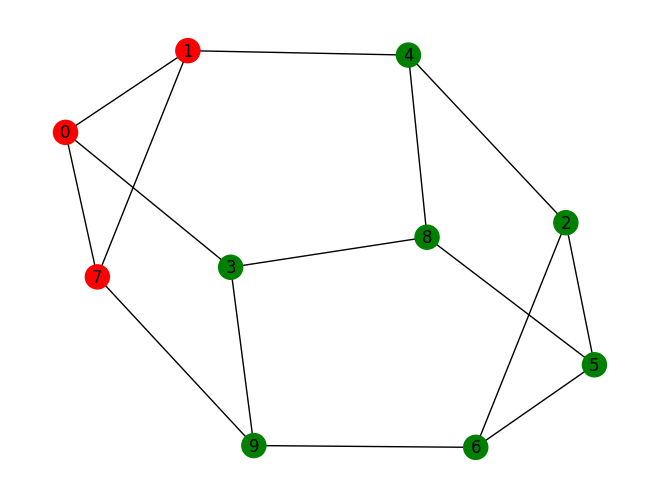

Se genera el tiempo  0.1873088242427314
Se selecciona al individuo 1
infectado por estar en el grupo con  -1


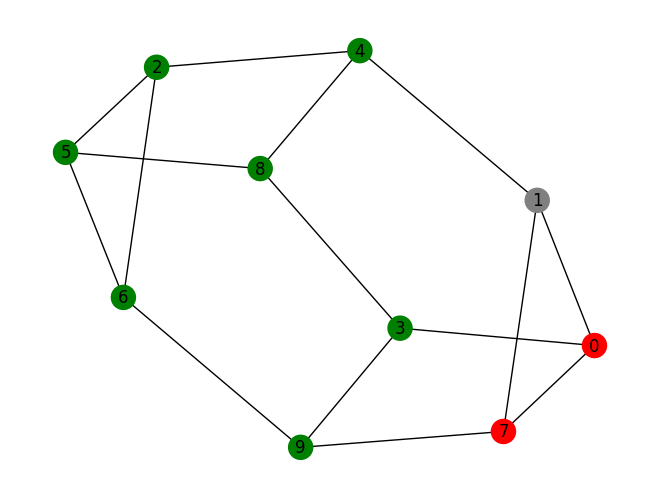

Se genera el tiempo  0.33375420878504897
Se selecciona al individuo 3
infectado por estar en el grupo con  1


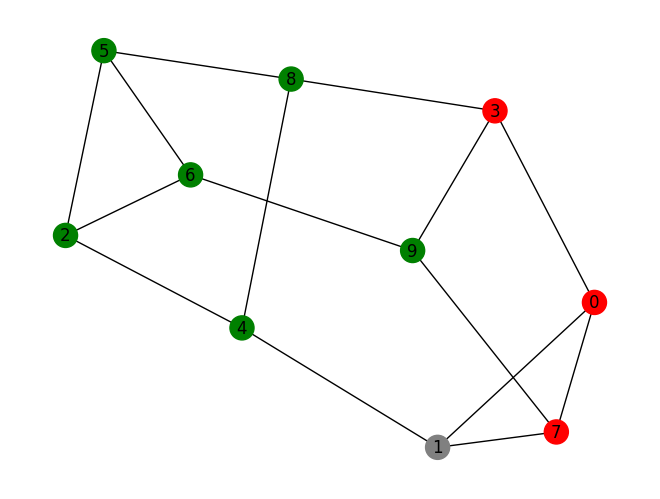

Se genera el tiempo  0.10018014096450015
Se selecciona al individuo 0
infectado por estar en el grupo con  -1


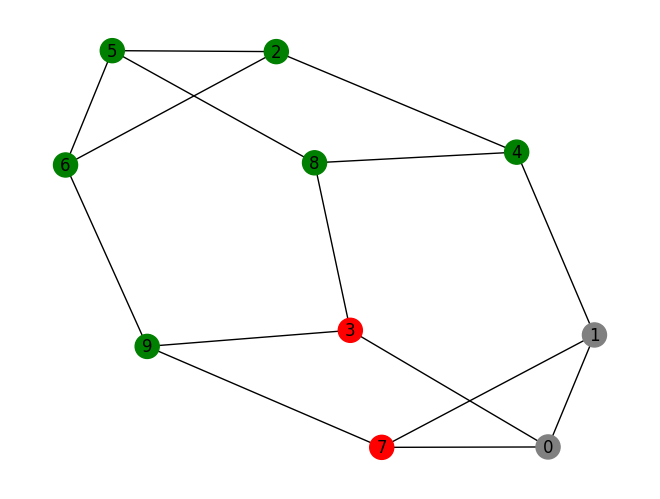

Se genera el tiempo  0.03772142897042152
Se selecciona al individuo 3
infectado por estar en el grupo con  -1


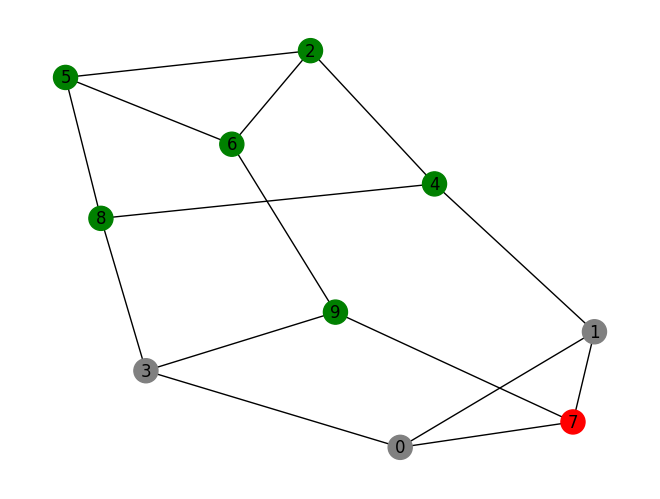

Se genera el tiempo  0.3870839405373161
Se selecciona al individuo 7
infectado por estar en el grupo con  -1


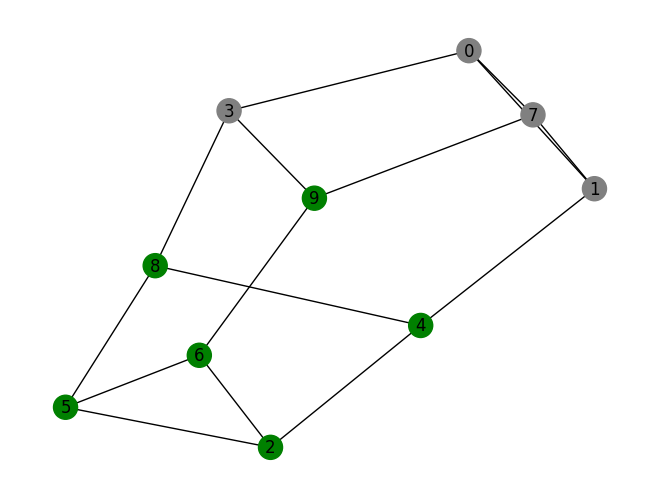

In [ ]:
N=10
n=3
G=nx.random_regular_graph(n,N)
X_I_indexes=[0]
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
nx.draw(G_copy,node_color=['green' if G_copy.nodes[i]['Estado:']=='Susceptible' else 'red' if G_copy.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in range(len(list(G_copy.nodes)))],with_labels=True)
plt.show()
print("Empieza")
H=Gillespie_Direct_Method_Network(beta=1.25,gamma=1,N=N,X_I_indexes=[0],G_network_initial=G_copy,T=np.inf,Tuto=True)

# SIS

Voy a hacer la modificación hacia el SIS, igual de forma gráfica usando $Tuto=True$. Además, se agrega un parámetro times_edges_count que es un arreglo de tiempos en el que se contará el número de conexiones Susceptibles-Infecciosas en la gráfica.

In [35]:
def Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(len(X_I_indexes)==1):#Se puede acabar
        u_2=0#forzar la infeccion
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación--
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network_SIS(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in G_network_initial.nodes():
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    hist_N_SI=[[len(list(G_network_initial.neighbors(X_I_indexes[0]))),1]]
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        try:
            Lambdas=[]
            for k in list(dict_num_contacts.keys()):
                k=int(k)
                Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
                Lambda+=Lambdas[-1]
            Lambdas.append(gamma*X_I)
            Lambda+=Lambdas[-1]
        except:
            print(dict_num_contacts.keys())
            print(dict_num_contacts[str(k)])
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            #num_cont_inf_por_indice[new_reaction]=0#Una vez que se infecta, ignoramos momentaneamente el número de contactos infecciosos que tenía, pues ya no se puede volver a contagiar.
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo 
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:# Paso de infeccioso a susceptible otra vez.
            X_I-=1
            X_S+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Susceptible'
            #------------------ Volvemos a contar sus contactos infecciosos.
            num_cont_inf_por_indice[new_reaction]=0
            for neig in G_network_initial.neighbors(new_reaction):
                if(G_network_initial.nodes[neig]['Estado:']=='Infeccioso'):
                    num_cont_inf_por_indice[new_reaction]+=1
            #-------------------
            X_I_indexes.pop(new_reaction_index)#Lo saca de infecciosos
            #----------------- Lo volvemos a ubicar en susceptibles
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            if(num_cont_inf_por_indice[new_reaction]>num_max_cont):#Si mas de uno crea una categoria, hay error.
                num_max_cont+=1
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))]=[new_reaction]
            else:
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))].append(new_reaction)
            
            #-----------------
            i=new_reaction
            #print(i, "es el que se va a recuperar")
            #----------------- Actualizamos el numero de contactos de sus vecinos.
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    #print("Su vecino ", vecino, ' esta en la categoria de ', num_cont_del_vecino)
                    if(G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                        dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)#Actualizamos el numero de contactos infecciones en -1
                        dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                        num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion

            #-------------------------------------------
        t+=tau #Actualiza el tiempo 
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        N_SI=0
        for node in G_network_initial.nodes():
            if G_network_initial.nodes[node]['Estado:']=='Susceptible':
                for neig in G_network_initial.neighbors(node):
                    if G_network_initial.nodes[neig]['Estado:']=='Infeccioso':
                        N_SI+=1
        hist_N_SI.append([N_SI,X_I])
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0 or t>T):
            flag=False
    return Historia,hist_N_SI

In [36]:
N=1000
n=20
G=nx.fast_gnp_random_graph(n=N,p=n/N)
print(G.nodes())
G=nx.convert_node_labels_to_integers(G,ordering='default',)
print(G.nodes())
print(nx.is_connected(G))
X_I_indexes=[list(G.nodes)[0]]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
np.random.seed(21)
print("Empieza")
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.25,gamma=1,N=N,X_I_indexes=[0],G_network_initial=G_copy,T=10,Tuto=False)
print(len(H))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

KeyError: ignored

In [21]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r

In [22]:
conteo_promedio

,N_SI,approx
k,,
1,20.000000,19.98
2,38.000000,39.92
3,56.000000,59.82
4,74.000000,79.68
5,92.000000,99.50
...,...,...
975,487.267606,487.50
976,468.057143,468.48
977,448.347826,449.42


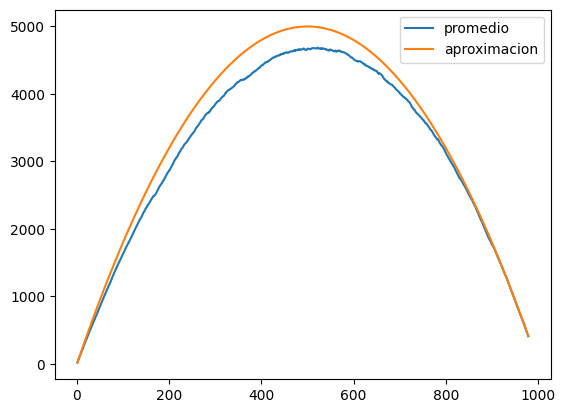

In [23]:
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])

In [ ]:
N=1000
n=200
G=nx.random_regular_graph(n,N)
print(G.nodes())
G=nx.convert_node_labels_to_integers(G,ordering='default',)
print(G.nodes())
X_I_indexes=[list(G.nodes)[0]]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()

print("Empieza")
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.25,gamma=1,N=N,X_I_indexes=[0],G_network_initial=G_copy,T=10,Tuto=False)
print(len(H))

[132, 268, 343, 488, 876, 951, 191, 848, 251, 899, 339, 746, 394, 453, 397, 724, 113, 965, 144, 278, 185, 279, 300, 791, 336, 448, 295, 447, 396, 499, 107, 148, 929, 962, 492, 961, 203, 858, 198, 514, 146, 324, 304, 910, 15, 807, 698, 837, 338, 494, 450, 735, 491, 736, 166, 976, 202, 633, 702, 956, 348, 458, 204, 679, 259, 386, 350, 504, 451, 556, 162, 542, 674, 654, 915, 253, 571, 693, 843, 598, 983, 104, 151, 294, 596, 744, 808, 804, 859, 463, 566, 895, 977, 707, 926, 254, 392, 345, 510, 498, 752, 709, 972, 456, 526, 459, 797, 644, 154, 161, 271, 651, 967, 799, 865, 572, 265, 931, 213, 741, 361, 639, 72, 536, 452, 757, 75, 460, 618, 264, 706, 267, 69, 238, 74, 582, 449, 509, 225, 751, 266, 854, 755, 916, 34, 402, 125, 520, 120, 176, 521, 218, 711, 410, 881, 516, 616, 280, 27, 362, 407, 583, 868, 978, 118, 480, 219, 532, 558, 670, 993, 803, 86, 942, 461, 819, 276, 285, 667, 695, 484, 988, 119, 301, 234, 813, 382, 863, 984, 173, 537, 778, 228, 244, 35, 603, 40, 947, 764, 100, 998, 475,

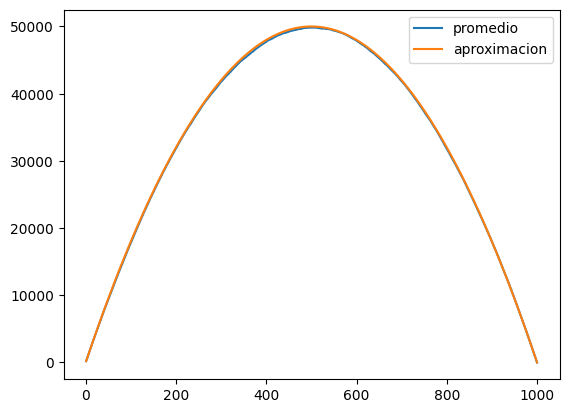

In [ ]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])